## Imports

In [0]:
!pip install opencv-python
!pip install matplotlib
!pip install sklearn

import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.utils import shuffle
import random

%tensorflow_version 2.x
import tensorflow as tf
import os

# tf1.disable_v2_behavior()

import tensorflow.keras
import tensorflow.keras.backend as K
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, Activation, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D, MaxPooling2D, ZeroPadding2D, Add, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import optimizers
from time import time

Using TensorFlow backend.


In [0]:
SIGN_SIZE = (32, 32)
num_classes = 43
TRAIN_PERCENTAGE = 0.8
VAL_PERCENTAGE = 0.1

## Fetch dataset

In [0]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
!unzip GTSRB-Training_fixed.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Training/00030/00007_00025.ppm  
  inflating: GTSRB/Training/00030/00007_00026.ppm  
  inflating: GTSRB/Training/00030/00007_00027.ppm  
  inflating: GTSRB/Training/00030/00007_00028.ppm  
  inflating: GTSRB/Training/00030/00007_00029.ppm  
  inflating: GTSRB/Training/00030/00008_00000.ppm  
  inflating: GTSRB/Training/00030/00008_00001.ppm  
  inflating: GTSRB/Training/00030/00008_00002.ppm  
  inflating: GTSRB/Training/00030/00008_00003.ppm  
  inflating: GTSRB/Training/00030/00008_00004.ppm  
  inflating: GTSRB/Training/00030/00008_00005.ppm  
  inflating: GTSRB/Training/00030/00008_00006.ppm  
  inflating: GTSRB/Training/00030/00008_00007.ppm  
  inflating: GTSRB/Training/00030/00008_00008.ppm  
  inflating: GTSRB/Training/00030/00008_00009.ppm  
  inflating: GTSRB/Training/00030/00008_00010.ppm  
  inflating: GTSRB/Training/00030/00008_00011.ppm  
  inflating: GTSRB/Training/00030/00008_00012.ppm  
  inflating: 

In [0]:
def readGTSRB(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            image_resized = cv2.resize(plt.imread(prefix + row[0]), SIGN_SIZE)      
            images.append(image_resized) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [0]:
gtrsrb_signs, gtrsrb_labels = readGTSRB('./GTSRB/Training')

In [0]:
IMG_HEIGHT = 600

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2020-03-31 13:13:04--  http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
Resolving www.dia.fi.upm.es (www.dia.fi.upm.es)... 138.100.11.29
Connecting to www.dia.fi.upm.es (www.dia.fi.upm.es)|138.100.11.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  11.2MB/s    in 2m 22s  

2020-03-31 13:15:25 (11.2 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.ppm  
  infla

In [0]:
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

## Model

In [0]:
from tensorflow.keras.applications import MobileNetV2

def get_traffic_sign_model(input_shape, num_classes, alpha):
   model = Sequential([
      MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=alpha),
      GlobalMaxPooling2D(),
      Dense(num_classes, activation='softmax')
   ])
   return model

# New Section

In [0]:
def visualize_accuracy(data):
  # Visualize model
  plt.plot(data.history['accuracy'])
  plt.plot(data.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def visualize_loss(data): 
  plt.plot(data.history['loss'])
  plt.plot(data.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Train

In [0]:
total_images = gtrsrb_signs + train_signs
total_labels = gtrsrb_labels + train_labels

train_limit = int(TRAIN_PERCENTAGE * len(total_images))
val_limit = int(train_limit + VAL_PERCENTAGE * len(total_images))

total_images, total_labels = shuffle(total_images, total_labels)

tr_total_images = np.array(total_images)[:train_limit]
tr_total_labels = np.array(total_labels)[:train_limit]
va_total_images = np.array(total_images)[train_limit:val_limit]
va_total_labels = np.array(total_labels)[train_limit:val_limit]
te_total_images = np.array(total_images)[val_limit:]
te_total_labels = np.array(total_labels)[val_limit:]

tr_total_images = tr_total_images.astype('float32')
va_total_images = va_total_images.astype('float32')
te_total_images = te_total_images.astype('float32')

tr_total_images /= 255.0
va_total_images /= 255.0
te_total_images /= 255.0

tr_total_labels = np_utils.to_categorical(tr_total_labels, num_classes)
va_total_labels = np_utils.to_categorical(va_total_labels, num_classes)
te_total_labels = np_utils.to_categorical(te_total_labels, num_classes)

In [0]:
# traffic_sign_model = get_traffic_sign_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes, alpha=0.5)
# traffic_sign_model.compile(loss='categorical_crossentropy', 
#             optimizer="Adamax", 
#             metrics=['accuracy'])

# traffic_sign_model.summary()

In [0]:
# traffic_sign_model_data = traffic_sign_model.fit(tr_total_images, tr_total_labels,
#         batch_size=48,
#         epochs=35,
#         verbose=2,
#         validation_data=(va_total_images, va_total_labels))

In [0]:
# start = time()
# loss, acc = traffic_sign_model.evaluate(te_total_images, te_total_labels, verbose=1)
# end = time()
# print('CNN took ' + str(end - start) + ' seconds')
# print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

In [0]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, fill_mode='nearest')
datagen.fit(tr_total_images, augment=True)

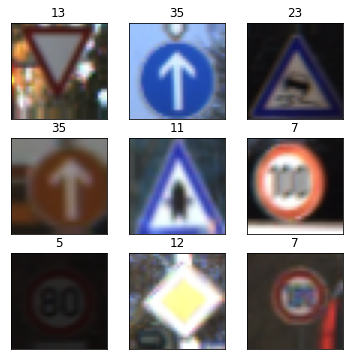

In [0]:
for x_batch, y_batch in datagen.flow(tr_total_images, tr_total_labels, batch_size=64):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(x_batch[i])
    # show the plot
    plt.show()
    break

In [0]:
traffic_sign_model_preproc = get_traffic_sign_model(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), num_classes = num_classes, alpha=0.5)
traffic_sign_model_preproc.compile(loss='categorical_crossentropy', 
            optimizer="Adamax", 
            metrics=['accuracy'])

traffic_sign_model_preproc.summary()

3203072/3201480 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.50_224 (Model) (None, 1, 1, 1280)        706224    
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                55083     
Total params: 761,307
Trainable params: 742,763
Non-trainable params: 18,544
_________________________________________________________________


In [48]:
batch_size = 64
train_steps = int(len(tr_total_images) // batch_size)
valid_steps = int(len(va_total_images) // batch_size)

traffic_sign_model_preproc_data = traffic_sign_model_preproc.fit(datagen.flow(tr_total_images, tr_total_labels, batch_size=batch_size), 
                         epochs=10, 
                         steps_per_epoch=train_steps, 
                         verbose=2, 
                         validation_data=(va_total_images, va_total_labels), 
                         validation_steps=valid_steps)

Epoch 1/10
343/343 - 15s - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0436 - val_accuracy: 0.9902
Epoch 2/10
343/343 - 15s - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.0641 - val_accuracy: 0.9782
Epoch 3/10
343/343 - 14s - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0395 - val_accuracy: 0.9880
Epoch 4/10
343/343 - 14s - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.0329 - val_accuracy: 0.9927
Epoch 5/10
343/343 - 15s - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.0736 - val_accuracy: 0.9774
Epoch 6/10
343/343 - 14s - loss: 0.0171 - accuracy: 0.9940 - val_loss: 0.0630 - val_accuracy: 0.9825
Epoch 7/10
343/343 - 14s - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0568 - val_accuracy: 0.9811
Epoch 8/10
343/343 - 14s - loss: 0.0157 - accuracy: 0.9946 - val_loss: 0.0697 - val_accuracy: 0.9782
Epoch 9/10
343/343 - 14s - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.1705 - val_accuracy: 0.9527
Epoch 10/10
343/343 - 14s - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0731 - val_accura

In [47]:
start = time()
loss, acc = traffic_sign_model_preproc.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')

86/86 [==============================] - 1s 11ms/step - loss: 0.0837 - accuracy: 0.9815
CNN took 0.9721381664276123 seconds


In [0]:
# Average 0.75 => 1.15
start = time()
loss, acc = traffic_sign_model_preproc.evaluate(te_total_images, te_total_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')

86/86 [==============================] - 1s 13ms/step - loss: 0.0254 - accuracy: 0.9949
CNN took 1.1966700553894043 seconds


### Test in GTSDB dataset 

In [0]:
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

te_signs = te_signs.astype('float32')
te_signs /= 255.0

te_labels = to_categorical(te_labels, num_classes)

In [0]:
start = time()
loss, acc = traffic_sign_model_preproc.evaluate(te_signs, te_labels, verbose=1)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

12/12 [==============================] - 0s 26ms/step - loss: 0.1175 - accuracy: 0.9612
CNN took 0.36571335792541504 seconds
Test loss: 0.1175471767783165 - Accuracy: 0.9612188339233398


### Graphics

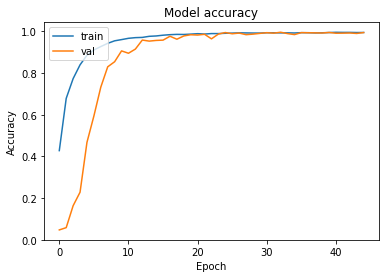

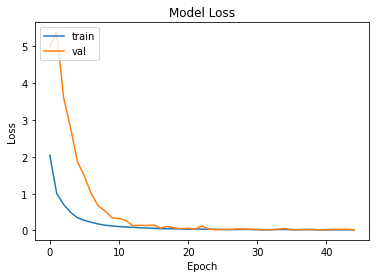

In [0]:
visualize_accuracy(traffic_sign_model_preproc_data)
visualize_loss(traffic_sign_model_preproc_data)

### Save the moodel

In [0]:
!rm -rf traffic_sign_model/*
!mkdir traffic_sign_model
traffic_sign_model_preproc.save_weights("traffic_sign_model/traffic_sign_model")
!zip -r traffic_sign_model.zip traffic_sign_model

  adding: traffic_sign_model/ (stored 0%)
  adding: traffic_sign_model/traffic_sign_model.data-00000-of-00002 (deflated 90%)
  adding: traffic_sign_model/traffic_sign_model.index (deflated 80%)
  adding: traffic_sign_model/checkpoint (deflated 42%)
  adding: traffic_sign_model/traffic_sign_model.data-00001-of-00002 (deflated 9%)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
!cp traffic_sign_model.zip /content/drive/My\ Drive/Colab\ Notebooks/Deep\ Learning/Assignment\ 3